## 2 Image compression using clustering [40 points]

In this programming assignment, you are going to apply clustering algorithms for image compression. Your task is implementing the clustering parts with two algorithms: *$K$-means* and *$K$-medoids*. **It is required you implementing the algorithms yourself rather than calling from a package.** <br>

*Before starting this assignment, we strongly recommend reading PRML Section 9.1.1, page 428 -- 430.*

**$K$-medoids**

In class, we learned that the basic $K$-means works in Euclidean space for computing distance between data points as well as for updating centroids by arithmetic mean. Sometimes, however, the dataset may work better with other distance measures. It is sometimes even impossible to compute arithmetic mean if a feature is categorical, e.g, gender or nationality of a person. With $K$-medoids, you choose a representative data point for each cluster instead of computing their average. Please note that $K$-medoid is different from generalized $K$-means: Generalized $K$-means still computes centre of a cluster is not necessarily one of the input data points (it is a point that minimizes the overall distance to all points in a cluster in a chosen distance metric). 

Given $m$ data points $\text x^i (i = 1, \ldots, m)$, $K$-medoids clustering algorithm groups them into $K$ clusters by minimizing the distortion function $J = \sum_{i=1}^m \sum_{j=1}^k r^{ij} D(\text x^i, \mu^j)$,
where $D(\text x, \text y)$ is a distance measure between two vectors $\text x$ and $\text y$ in same size (in case of $K$-means, $D(x, y) = \| \text x - \text y \|^2$), $\mu^j$ is the center of $j$-th cluster; and $r^{ij} = 1$ if $\text x^n$ belongs to the $k$-th cluster and $r^{ij} = 0$ otherwise. In this exercise, we will use the following iterative procedure:



* Initialize the cluster center $\mu^j$, $j = 1, ..., k$.
* Iterate until convergence: <br>
    -- Update the cluster assignments for every data point $\text x^i$: $r^{ij} = 1$ if $j = \arg\min_j D(\text x^i, \mu^j)$, and $r^{ij} = 0$ otherwise. <br>
    -- Update the center for each cluster $j$: choosing another representative if necessary.
    
There can be many options to implement the procedure; for example, you can try many distance measures in addition to Euclidean distance, and also you can be creative for deciding a better representative of each cluster. We will not restrict these choices in this assignment. You are encouraged to try many distance measures as well as way of choosing representatives (e.g., $\ell_1$ norm).

#### Hand-in
1. (10 points) Within the $k$-medoids framework, you have several choices for detailed implementation. Explain how you designed and implemented details of your $K$-medoids algorithm, including (but not limited to) how you chose representatives of each cluster, what distance measures you tried and chose one, or when you stopped iteration.
2. (10 points) Attach a picture of your own. We recommend size of $320 \times 240$ or smaller. Run your $k$-medoids implementation with the picture you chose, as well as two pictures provided (**beach.bmp** and **football.bmp**), with several different $K$. (e.g, small values like 2 or 3, large values like 16 or 32) What did you observe with different $K$? How long does it take to converge for each $K$? Please write in your report. 
3. (10 points) Run your $k$-medoids implementation with different initial centroids/representatives. Does it affect final result? Do you see same or different result for each trial with different initial assignments? (We usually randomize initial location of centroids in general. To answer this question, an intentional poor assignment may be useful.) Please write in your report. 
4. (10 points) Repeat question 2 and 3 with $k$-means. Do you see significant difference between $K$-medoids and $k$-means, in terms of output quality, robustness, or running time? Please write in your report. 

In [12]:
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
from matplotlib.image import imread
import math
from PIL import Image
import os
import seaborn as sns; sns.set()
import time

In [13]:
def image_load(file_name):
    # Read image into ndarray
    img = imread(file_name)
    print('read image file as in : {}'.format(type(img)))
    plt.imshow(img)
    return img

In [14]:
def image_load_pil(file_name):
    # Read image into ndarray
    img = Image.open(file_name)
    img_array = np.array(img)
    print('Read image file in ndarray with shape: {}'.format(img_array.shape))
    display(img)
    
    return img_array

Read image file in ndarray with shape: (412, 620, 3)


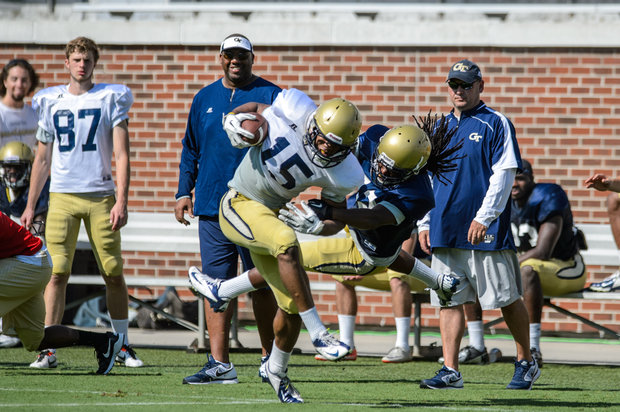

In [15]:
img = image_load_pil('football.bmp')

In [16]:
def array_to_img(img_array, ori_img):
    img_array = img_array*255
    img_array = np.round(img_array).astype(int)
    img_array = img_array.reshape(ori_img.shape)
    img_array = img_array.astype(np.uint8)
    new_image = Image.fromarray(img_array)
    display(new_image)
    return img_array

In [17]:
def image_array(img):
    print('image shape: {}'.format(img.shape))
    print('image dtype: {}'.format(img.dtype))
    c_img = img/255
    vec = c_img.reshape(-1,3)
    print('convert to array shape: {}'.format(vec.shape))
    print('convert to array dtype: {}'.format(vec.dtype))

    return vec

In [18]:
def initial_centroid_k(vec, k, random=True, index=[]):
   # Choose K sample as starting point to initialize   
    if random == True:
        ini_centroid_index = np.random.randint(vec.shape[0], size=(1, k))[0]
    else:
        ini_centroid_index = index
    ini_centroid = vec[ini_centroid_index]

    return ini_centroid 

In [19]:
def assign_labels(vec, centroid):
    dt = distance.cdist(vec, centroid, 'euclidean')
    labels = np.argmin(dt, axis=1)
    return labels

In [20]:
def re_calculate_centroid_sample(vec, labels):
    total_cost = 0
    new_k = len(set(labels))
    new_centroid = np.zeros(shape=(new_k, 3))
    for i in range(new_k):
        # print('For cluster {}:'.format(i))
        # create vectors of points in each cluster
        label_vector = vec[labels==list(set(labels))[i]]
        # downsampling to 15% of the data within each cluster
        sample_label = np.random.randint(len(label_vector),size = int(len(label_vector)*0.15))
        sample_vector = label_vector[sample_label]
        # calculate total distance cost between each pixel inside the cluster
        sample_cost = distance.cdist(sample_vector, sample_vector,'euclidean').sum(axis=1)
        # find the new representative centroid based on minimum distance
        
        centroid_index = np.argmin(sample_cost)
        new_centroid_i = sample_vector[centroid_index]
        
        # use the new centroid to calculate the cost of entire cluster
        new_cost = distance.cdist(label_vector, new_centroid_i.reshape(1,3),'euclidean').sum()
        new_centroid[i] = new_centroid_i
        total_cost += new_cost    
    
    
    return new_centroid, total_cost

In [21]:
def centroid_change_pct(old_centroid, new_centroid):
    overlap_centroid = set([tuple(x) for x in old_centroid]).intersection(set([tuple(x) for x in new_centroid]))
    return len(overlap_centroid)*1.00/len(old_centroid)

In [22]:
def cluster_change_pct(old_label, new_label):
    return (old_label==new_label).sum()/len(old_label)

In [23]:
def k_medoid(image, k,  random=True, index=[]):
    start_t = time.time()
    print('image loading...')
    img = image_load_pil(image)
    print('image converted to array...')
    vec = image_array(img)
    ini_centroid = initial_centroid_k(vec, k, random, index)
    
    # based on total cost
    x = 0
    i = 0
    
    centroid = ini_centroid
    labels = assign_labels(vec, centroid)
    total_cost_ls = []
    cost_impr_pct = 1
    print('iteration start ......')
    
    while (x <= 0.98) or (cost_impr_pct > 0.05) or (cost_impr_pct < 0):
        print('Iteration: {}'.format(i))
        print('.....................')
        i = i+1

        # re-calculate centroid based on labels
        [new_centroid, total_cost] = re_calculate_centroid_sample(vec, labels)    
        previous_cost = total_cost
        labels = assign_labels(vec, new_centroid)
        
        
        # downsampling but keep iterating till find a decreased total cost
        while total_cost >= previous_cost:
            [new_centroid, total_cost] = re_calculate_centroid_sample(vec, labels)
            new_labels = assign_labels(vec, new_centroid)
        
        prebious_cost = total_cost
        print('total new cost: {:.1f}'.format(total_cost))
        cost_impr_pct = (previous_cost-total_cost)/previous_cost 
        x = cluster_change_pct(labels, new_labels)
        labels = new_labels
        total_cost_ls.append(total_cost)
    
    
    print('generate new image ......')
    new_vec = np.zeros(vec.shape)
    for x in range(len(new_centroid)):
        new_vec[labels==x] = new_centroid[x]
    new_image = array_to_img(new_vec, img)
    
    print('Running time: {:.1f} second'.format(time.time()-start_t))
    
    print('Total Cost Trend:')
    trend = sns.lineplot(x=np.arange(i), y=total_cost_ls)
    trend.set(xlabel='Iteration', ylabel='Total Cost', title='Total Cost Trend Over Iteration')
    return new_centroid, total_cost_ls, new_image

image loading...
Read image file in ndarray with shape: (412, 620, 3)


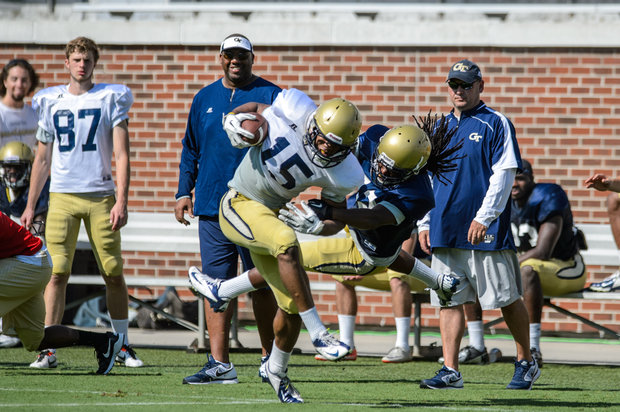

image converted to array...
image shape: (412, 620, 3)
image dtype: uint8
convert to array shape: (255440, 3)
convert to array dtype: float64
iteration start ......
Iteration: 0
.....................
total new cost: 38265.9
Iteration: 1
.....................
total new cost: 38141.0
generate new image ......


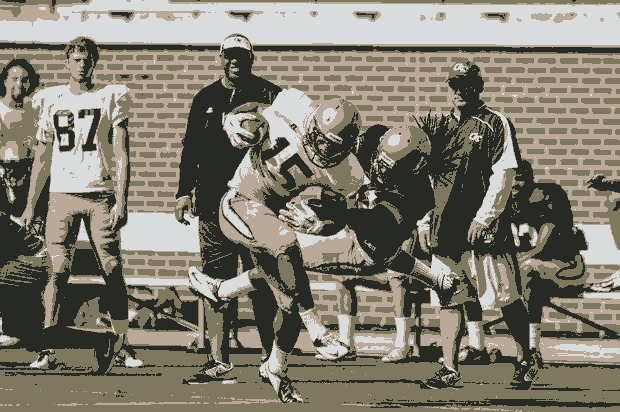

Running time: 15.5 second
Total Cost Trend:


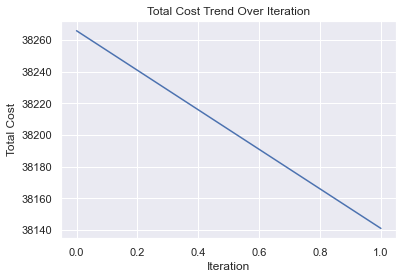

In [24]:
new_centroid, total_cost_ls, new_image = k_medoid('football.bmp', 4)

image loading...
Read image file in ndarray with shape: (412, 620, 3)


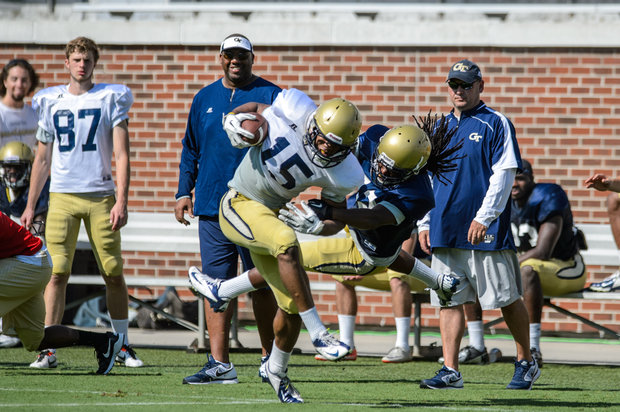

image converted to array...
image shape: (412, 620, 3)
image dtype: uint8
convert to array shape: (255440, 3)
convert to array dtype: float64
iteration start ......
Iteration: 0
.....................
total new cost: 25355.8
Iteration: 1
.....................
total new cost: 21768.7
Iteration: 2
.....................
total new cost: 20593.9
Iteration: 3
.....................
total new cost: 20277.6
Iteration: 4
.....................
total new cost: 20082.8
Iteration: 5
.....................
total new cost: 19985.0
Iteration: 6
.....................
total new cost: 19897.1
generate new image ......


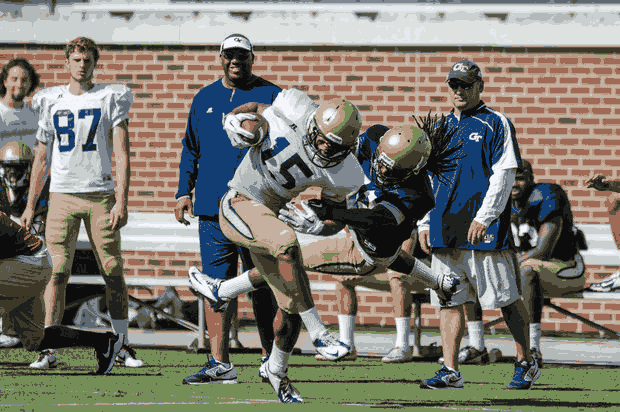

Running time: 20.0 second
Total Cost Trend:


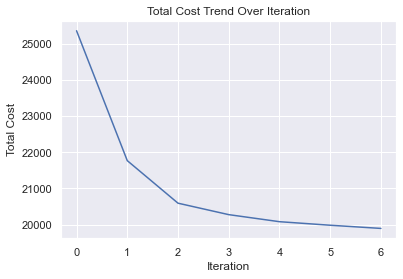

In [25]:
new_centroid, total_cost_ls, new_image = k_medoid('football.bmp', 16)

image loading...
Read image file in ndarray with shape: (214, 320, 3)


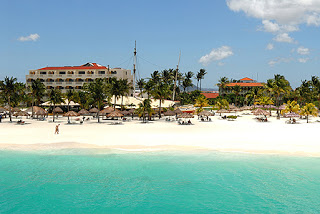

image converted to array...
image shape: (214, 320, 3)
image dtype: uint8
convert to array shape: (68480, 3)
convert to array dtype: float64
iteration start ......
Iteration: 0
.....................
total new cost: 11703.8
Iteration: 1
.....................
total new cost: 11037.4
generate new image ......


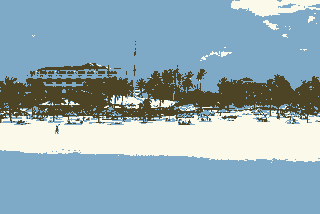

Running time: 1.9 second
Total Cost Trend:


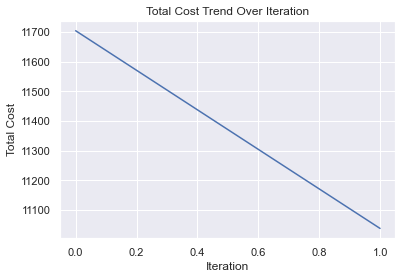

In [26]:
new_centroid, total_cost_ls, new_image = k_medoid('beach.bmp', 3)

image loading...
Read image file in ndarray with shape: (214, 320, 3)


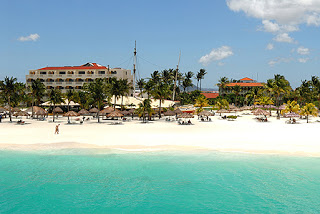

image converted to array...
image shape: (214, 320, 3)
image dtype: uint8
convert to array shape: (68480, 3)
convert to array dtype: float64
iteration start ......
Iteration: 0
.....................
total new cost: 4309.5
Iteration: 1
.....................
total new cost: 4197.7
Iteration: 2
.....................
total new cost: 4155.7
generate new image ......


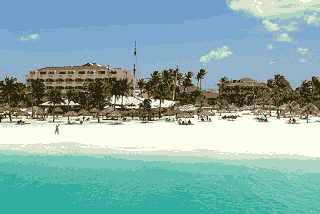

Running time: 1.3 second
Total Cost Trend:


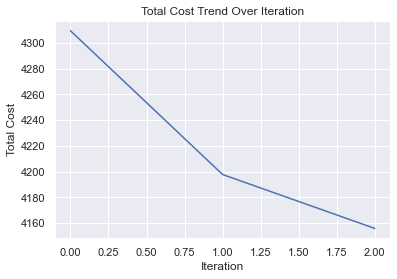

In [27]:
new_centroid, total_cost_ls, new_image = k_medoid('beach.bmp', 15)

image loading...
Read image file in ndarray with shape: (240, 320, 3)


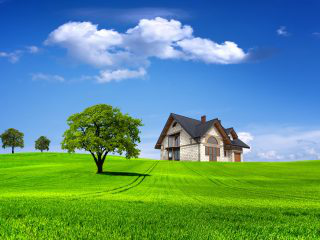

image converted to array...
image shape: (240, 320, 3)
image dtype: uint8
convert to array shape: (76800, 3)
convert to array dtype: float64
iteration start ......
Iteration: 0
.....................
total new cost: 13748.5
Iteration: 1
.....................
total new cost: 12912.7
Iteration: 2
.....................
total new cost: 12745.2
generate new image ......


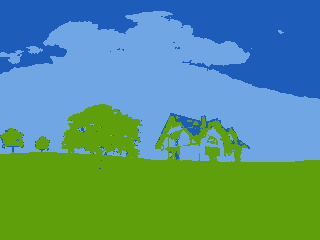

Running time: 2.9 second
Total Cost Trend:


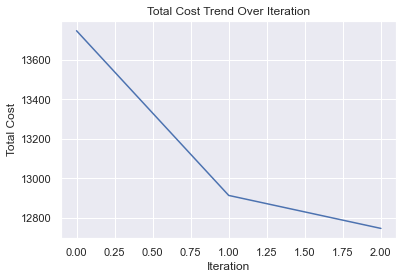

In [28]:
new_centroid, total_cost_ls, new_image = k_medoid('sample photo.jpg', 3)

image loading...
Read image file in ndarray with shape: (240, 320, 3)


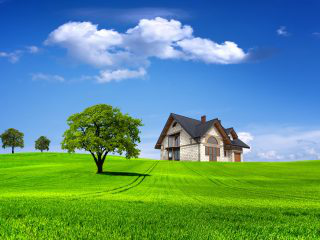

image converted to array...
image shape: (240, 320, 3)
image dtype: uint8
convert to array shape: (76800, 3)
convert to array dtype: float64
iteration start ......
Iteration: 0
.....................
total new cost: 5379.8
Iteration: 1
.....................
total new cost: 5219.8
Iteration: 2
.....................
total new cost: 5113.1
Iteration: 3
.....................
total new cost: 5072.0
Iteration: 4
.....................
total new cost: 5047.9
Iteration: 5
.....................
total new cost: 5031.4
Iteration: 6
.....................
total new cost: 5022.0
Iteration: 7
.....................
total new cost: 5003.8
Iteration: 8
.....................
total new cost: 4994.9
Iteration: 9
.....................
total new cost: 4992.4
generate new image ......


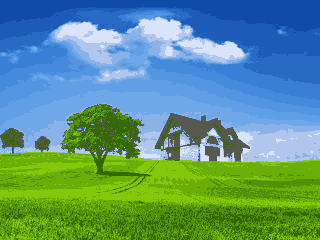

Running time: 5.2 second
Total Cost Trend:


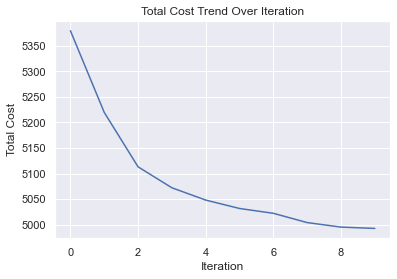

In [29]:
new_centroid, total_cost_ls, new_image = k_medoid('sample photo.jpg', 16)

#### 2.3 Different initial K

#### Special starting point of K
As above in the function of initial_centroid_k, in below cases, the K is specially set up as the 1st K array of the image vectors

-- K-Medoids

image loading...
Read image file in ndarray with shape: (240, 320, 3)


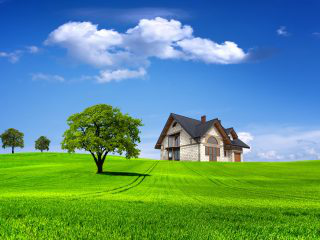

image converted to array...
image shape: (240, 320, 3)
image dtype: uint8
convert to array shape: (76800, 3)
convert to array dtype: float64
iteration start ......
Iteration: 0
.....................
total new cost: 8246.5
Iteration: 1
.....................
total new cost: 6621.5
Iteration: 2
.....................
total new cost: 6312.5
Iteration: 3
.....................
total new cost: 6218.5
Iteration: 4
.....................
total new cost: 6067.9
Iteration: 5
.....................
total new cost: 5952.2
Iteration: 6
.....................
total new cost: 5932.4
Iteration: 7
.....................
total new cost: 5922.8
generate new image ......


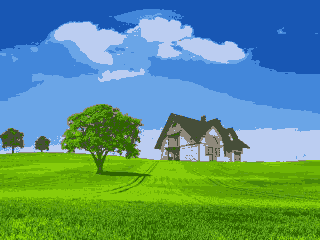

Running time: 5.3 second
Total Cost Trend:


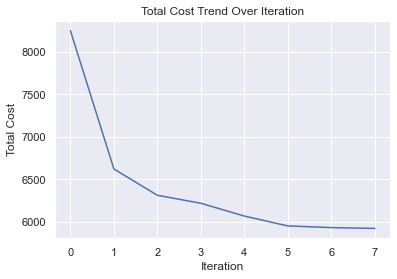

In [30]:
# set special starting point as the first 16 points
new_centroid, total_cost_ls, new_image = k_medoid('sample photo.jpg', 16, False, list(range(16)))

image loading...
Read image file in ndarray with shape: (240, 320, 3)


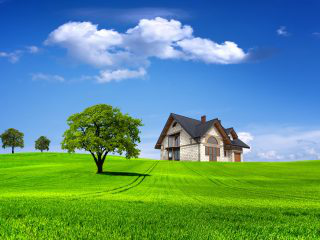

image converted to array...
image shape: (240, 320, 3)
image dtype: uint8
convert to array shape: (76800, 3)
convert to array dtype: float64
iteration start ......
Iteration: 0
.....................
total new cost: 17579.4
Iteration: 1
.....................
total new cost: 17572.5
generate new image ......


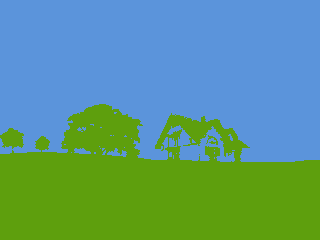

Running time: 2.9 second
Total Cost Trend:


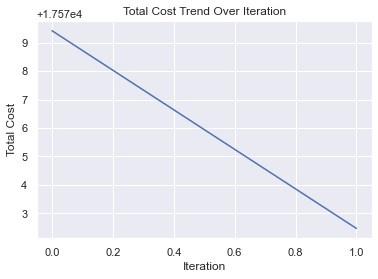

In [31]:
# set special starting point as the first 3 points
new_centroid, total_cost_ls, new_image = k_medoid('sample photo.jpg', 3, False, list(range(3)))

-- K-means (functions defined in below 2.4)

image loading...
Read image file in ndarray with shape: (240, 320, 3)


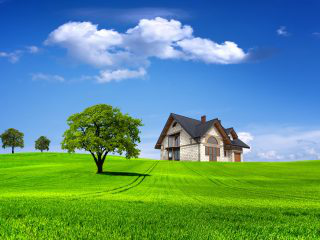

image converted to array...
image shape: (240, 320, 3)
image dtype: uint8
convert to array shape: (76800, 3)
convert to array dtype: float64
iteration start ......
Iteration: 0
.....................
total new cost: 13445.698954153304
Iteration: 1
.....................
total new cost: 13344.35682692442
generate new image ......


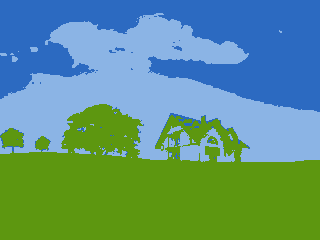

Running time: 0.1 second
Total Cost Trend:


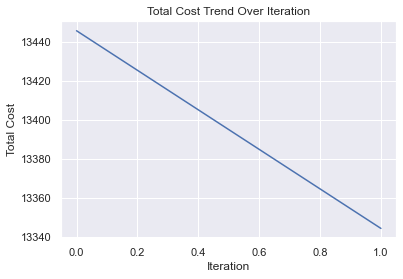

In [35]:
new_centroid, total_cost_ls, new_image = k_means('sample photo.jpg', 3, False, list(range(3)))

image loading...
Read image file in ndarray with shape: (240, 320, 3)


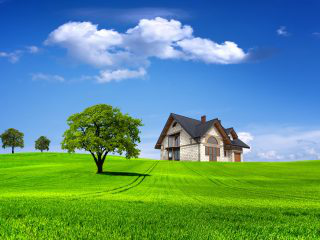

image converted to array...
image shape: (240, 320, 3)
image dtype: uint8
convert to array shape: (76800, 3)
convert to array dtype: float64
iteration start ......
Iteration: 0
.....................
total new cost: 6046.894872796796
Iteration: 1
.....................
total new cost: 5487.417928758611
Iteration: 2
.....................
total new cost: 5201.3164340055955
Iteration: 3
.....................
total new cost: 5068.687484435271
Iteration: 4
.....................
total new cost: 5008.841545991598
generate new image ......


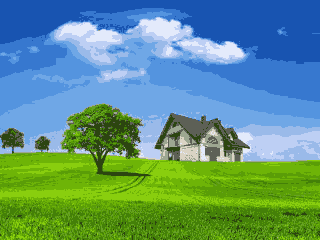

Running time: 0.2 second
Total Cost Trend:


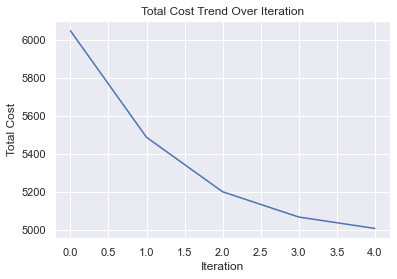

In [36]:
new_centroid, total_cost_ls, new_image = k_means('sample photo.jpg', 16, False, list(range(16)))

#### 2.4 K-means

In [33]:
def re_calculate_kmeans_centroid(vec, labels):
    total_cost = 0
    new_k = len(set(labels))
    new_centroid = np.zeros(shape=(new_k, 3))
    for i in range(new_k):
        # print('For cluster {}:'.format(i))
        # create vectors of points in each cluster
        label_vector = vec[labels==i]
        new_centroid_i = label_vector.mean(axis=0).reshape(1,3)
        
        # calculate total distance cost between each pixel inside the cluster
        new_cost = distance.cdist(label_vector, new_centroid_i,'euclidean').sum()
        # find the new representative centroid based on minimum distance
        
        total_cost += new_cost    
        new_centroid[i] = new_centroid_i
    return new_centroid, total_cost

In [34]:
def k_means(image, k, rando=True, index=[]):
    start_t = time.time()
    print('image loading...')
    img = image_load_pil(image)
    print('image converted to array...')
    vec = image_array(img)
    ini_centroid = initial_centroid_k(vec, k, random=True, index=[])
    # based on total cost
    x = 0
    i = 0
    
    # initialize centroid randomly
    centroid = ini_centroid
    
    # assign labels based on the shortest eucliean distance
    labels = assign_labels(vec, centroid)
    
    total_cost_ls = []
    cost_impr_pct = 1
    print('iteration start ......')
    
    while (cost_impr_pct > 0.02) or (cost_impr_pct < 0):
        print('Iteration: {}'.format(i))
        print('.....................')
        i = i+1
        # re-calculate mean as the centroid based on labels
        [new_centroid, total_cost] = re_calculate_kmeans_centroid(vec, labels) 
        
        print('total new cost: {}'.format(total_cost))
        
        new_labels = assign_labels(vec, new_centroid)
        x = centroid_change_pct(centroid, new_centroid)
        if i >1:
            previous_cost = total_cost_ls[-1]
            cost_impr_pct = (previous_cost-total_cost)/previous_cost
        labels = new_labels
        centroid = new_centroid
        total_cost_ls.append(total_cost)
    
    
    print('generate new image ......')
    new_vec = np.zeros(vec.shape)
    for x in range(len(new_centroid)):
        new_vec[labels==x] = new_centroid[x]
    new_image = array_to_img(new_vec, img)
    
    print('Running time: {:.1f} second'.format(time.time()-start_t))
    
    print('Total Cost Trend:')
    trend = sns.lineplot(x=np.arange(i), y=total_cost_ls)
    trend.set(xlabel='Iteration', ylabel='Total Cost', title='Total Cost Trend Over Iteration')
    
    return new_centroid, total_cost_ls, new_image

image loading...
Read image file in ndarray with shape: (240, 320, 3)


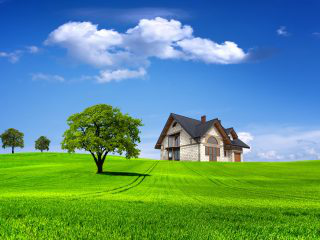

image converted to array...
image shape: (240, 320, 3)
image dtype: uint8
convert to array shape: (76800, 3)
convert to array dtype: float64
iteration start ......
Iteration: 0
.....................
total new cost: 17030.70587318211
Iteration: 1
.....................
total new cost: 15803.587957223539
Iteration: 2
.....................
total new cost: 14150.441691388069
Iteration: 3
.....................
total new cost: 13287.362081721376
Iteration: 4
.....................
total new cost: 13081.385169357116
generate new image ......


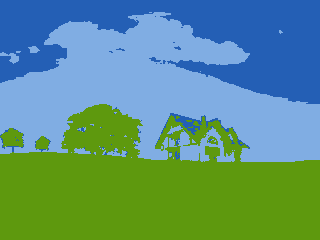

Running time: 0.1 second
Total Cost Trend:


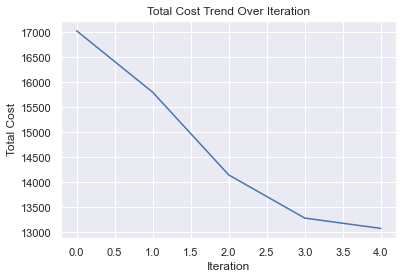

In [37]:
new_centroid, total_cost_ls, new_image = k_means('sample photo.jpg', 3)

image loading...
Read image file in ndarray with shape: (240, 320, 3)


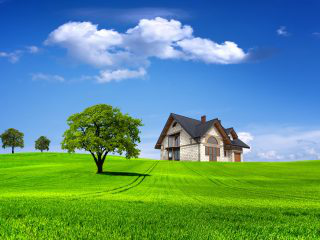

image converted to array...
image shape: (240, 320, 3)
image dtype: uint8
convert to array shape: (76800, 3)
convert to array dtype: float64
iteration start ......
Iteration: 0
.....................
total new cost: 6059.511449943036
Iteration: 1
.....................
total new cost: 5557.479466021084
Iteration: 2
.....................
total new cost: 5173.058900811152
Iteration: 3
.....................
total new cost: 5013.2517363356965
Iteration: 4
.....................
total new cost: 4940.072283299681
generate new image ......


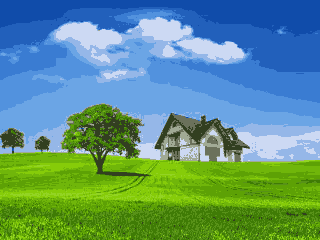

Running time: 0.2 second
Total Cost Trend:


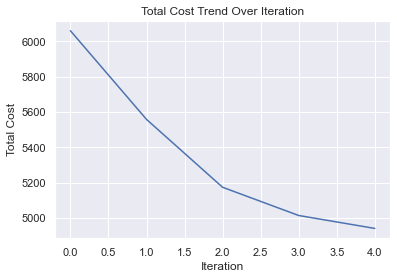

In [38]:
new_centroid, total_cost_ls, new_image = k_means('sample photo.jpg', 16)

image loading...
Read image file in ndarray with shape: (214, 320, 3)


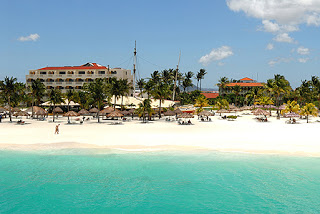

image converted to array...
image shape: (214, 320, 3)
image dtype: uint8
convert to array shape: (68480, 3)
convert to array dtype: float64
iteration start ......
Iteration: 0
.....................
total new cost: 15015.623420020993
Iteration: 1
.....................
total new cost: 13890.534086322139
Iteration: 2
.....................
total new cost: 12507.313750419518
Iteration: 3
.....................
total new cost: 11586.631763974383
Iteration: 4
.....................
total new cost: 11393.807826497785
generate new image ......


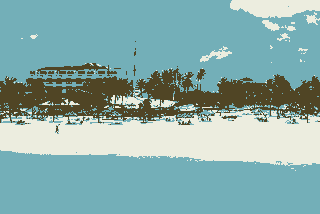

Running time: 0.1 second
Total Cost Trend:


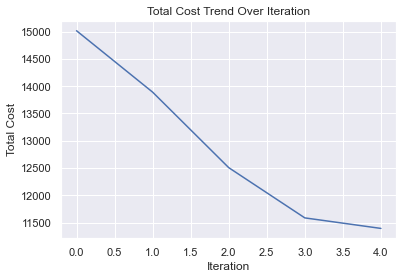

In [43]:
new_centroid, total_cost_ls, new_image = k_means('beach.bmp', 3)

image loading...
Read image file in ndarray with shape: (214, 320, 3)


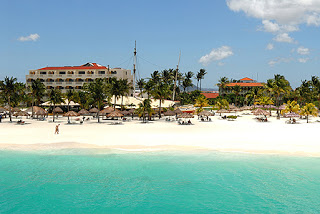

image converted to array...
image shape: (214, 320, 3)
image dtype: uint8
convert to array shape: (68480, 3)
convert to array dtype: float64
iteration start ......
Iteration: 0
.....................
total new cost: 5318.234638950164
Iteration: 1
.....................
total new cost: 4701.016738443451
Iteration: 2
.....................
total new cost: 4298.4262671488905
Iteration: 3
.....................
total new cost: 4210.319539296032
Iteration: 4
.....................
total new cost: 4172.869023131254
generate new image ......


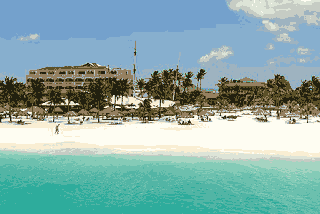

Running time: 0.3 second
Total Cost Trend:


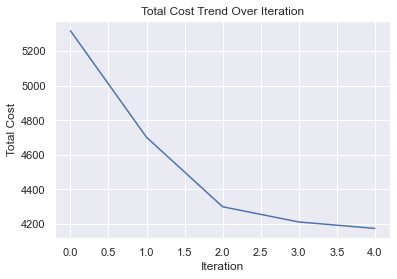

In [40]:
new_centroid, total_cost_ls, new_image = k_means('beach.bmp', 15)

image loading...
Read image file in ndarray with shape: (412, 620, 3)


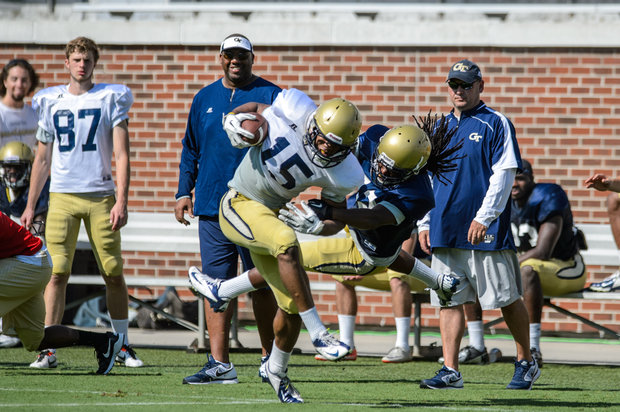

image converted to array...
image shape: (412, 620, 3)
image dtype: uint8
convert to array shape: (255440, 3)
convert to array dtype: float64
iteration start ......
Iteration: 0
.....................
total new cost: 47603.889411249314
Iteration: 1
.....................
total new cost: 42462.82758110508
Iteration: 2
.....................
total new cost: 40977.46022240148
Iteration: 3
.....................
total new cost: 39967.222174612034
Iteration: 4
.....................
total new cost: 39303.49054557468
generate new image ......


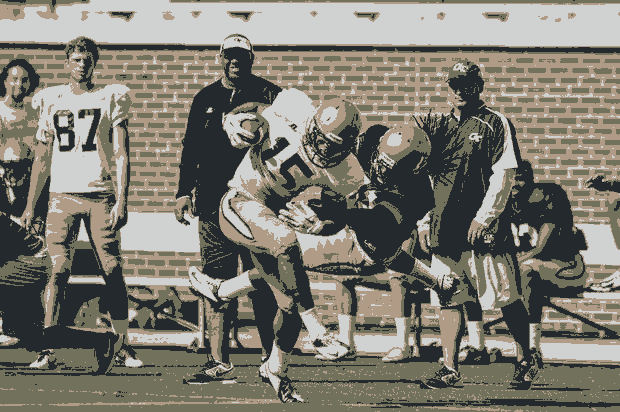

Running time: 0.5 second
Total Cost Trend:


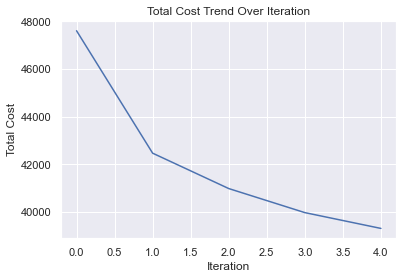

In [41]:
new_centroid, total_cost_ls, new_image = k_means('football.bmp', 4)

image loading...
Read image file in ndarray with shape: (412, 620, 3)


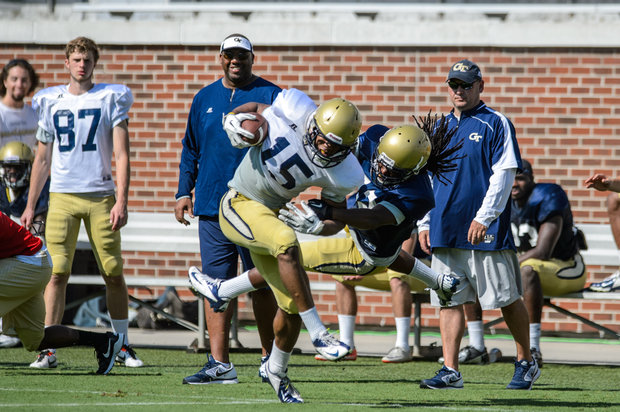

image converted to array...
image shape: (412, 620, 3)
image dtype: uint8
convert to array shape: (255440, 3)
convert to array dtype: float64
iteration start ......
Iteration: 0
.....................
total new cost: 22601.919842319083
Iteration: 1
.....................
total new cost: 20239.759072196102
Iteration: 2
.....................
total new cost: 19902.700845731895
generate new image ......


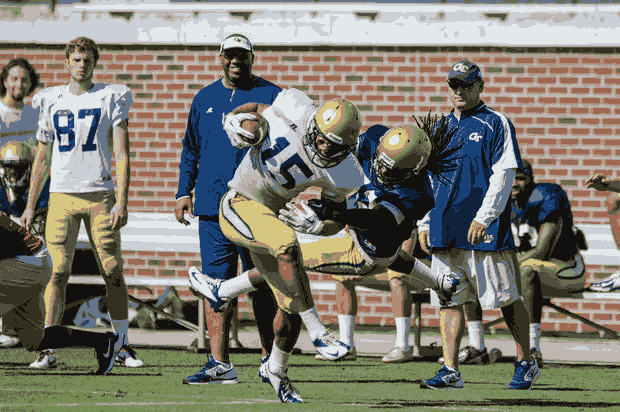

Running time: 0.5 second
Total Cost Trend:


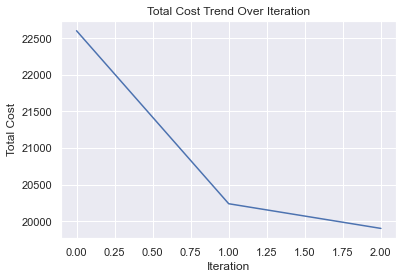

In [42]:
new_centroid, total_cost_ls, new_image = k_means('football.bmp', 16)